In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
import pandas as pd
import ast
import matplotlib.pyplot as plt
from ase.data import atomic_numbers

# Set target elements (optional filtering)
TARGET_ELEMENTS = None  # Set to None to include all elements, or {"Ni", "Ta", "Mn", "Sb"} for specific elements

# Load and filter data
def load_data(filepath):
    df = pd.read_csv(filepath)
    return df

# Preprocess to create graph data objects with normalization
def create_material_graph(structure_data, formation_energy):
    atoms = structure_data['data']['atoms']
    node_features = []
    positions = []

    # Normalize position features by dividing by 1e-10
    for atom in atoms:
        if TARGET_ELEMENTS is None or atom['element'] in TARGET_ELEMENTS:
            atomic_num = get_atomic_number(atom['element'])
            pos = [atom['x'] / 1e-10, atom['y'] / 1e-10, atom['z'] / 1e-10]
            dist = sum([x**2 for x in pos]) ** 0.5
            node_features.append([atomic_num] + pos + [dist])
            positions.append(pos)
    
    # Create edges based on distance threshold
    edge_index = []
    threshold = 2.0  # Increased to account for normalized values
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):
            if sum([(positions[i][k] - positions[j][k]) ** 2 for k in range(3)]) ** 0.5 < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])

    # Check if edge_index is empty, add self-loops if needed
    if not edge_index:
        edge_index = [[i, i] for i in range(len(positions))]

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor([formation_energy], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, y=y)

# Function to get atomic numbers for elements using ASE
def get_atomic_number(element_symbol):
    return atomic_numbers[element_symbol]

# Prepare dataset with filtering
def prepare_dataset(filepath):
    dataset = []
    data = load_data(filepath)
    for _, row in data.iterrows():
        try:
            structure_data = ast.literal_eval(row['structure'])[0]
            formation_energy = eval(row['formation_energy'])['value']
            
            # Filter out unphysically large formation energy values
            if formation_energy < -20:
                continue  # Skip this sample
            
            # Create the graph data for the valid sample
            graph = create_material_graph(structure_data, formation_energy)
            dataset.append(graph)
            
        except Exception as e:
            # print(f"Error processing row: {e}")
            continue  # Skip problematic rows
    return dataset

# Define model with increased complexity
class MaterialGraph(torch.nn.Module):
    def __init__(self):
        super(MaterialGraph, self).__init__()
        self.conv1 = GCNConv(in_channels=5, out_channels=64)      # First GCN layer
        self.conv2 = GCNConv(in_channels=64, out_channels=64)     # Second GCN layer
        self.conv3 = GCNConv(in_channels=64, out_channels=128)    # Third GCN layer with more features
        
        # Adjusted linear layers
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, 1)  # Make sure this matches the previous layer output

        # Optional dropout for regularization
        self.dropout = torch.nn.Dropout(p=0.3)  # Dropout to prevent overfitting

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply GCN layers with ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))    # Apply third GCN layer

        # Pooling and fully connected layers
        x = global_mean_pool(x, data.batch)      # Pool the features from all nodes
        x = F.relu(self.fc1(x))
        x = self.dropout(x)                      # Dropout before final layer
        x = self.fc2(x)

        return x


# Training and testing functions
def train(loader, model, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(loader, model):
    model.eval()
    total_loss = 0
    predictions, actuals = [], []
    with torch.no_grad():
        for data in loader:
            output = model(data)
            predictions.extend(output.view(-1).tolist())
            actuals.extend(data.y.view(-1).tolist())
            loss = F.mse_loss(output, data.y)
            total_loss += loss.item()
    return total_loss / len(loader), predictions, actuals

In [6]:
# Main script
filepath = '../Data/1_MatDX/MatDX_EF.csv'  # Replace with actual path

In [7]:
dataset = prepare_dataset(filepath)

In [8]:
# Split dataset into training and testing sets (70/30)
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

/Users/kisungkang/opt/miniconda3/envs/jupyter/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
model = MaterialGraph()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [11]:
# Training loop with evaluation on test set
epochs = 100
for epoch in range(1, epochs + 1):
    train_loss = train(train_loader, model, optimizer)
    if epoch % 10 == 0:
        test_loss, _, _ = test(test_loader, model)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

print("Training completed!")

/var/folders/ls/hmx5y4nn7g7733rbw77f4p940000gn/T/ipykernel_34855/3008535656.py:118: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, data.y)
/var/folders/ls/hmx5y4nn7g7733rbw77f4p940000gn/T/ipykernel_34855/3008535656.py:118: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, data.y)
/var/folders/ls/hmx5y4nn7g7733rbw77f4p940000gn/T/ipykernel_34855/3008535656.py:133: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, data.y)
/var

Epoch 10, Train Loss: 22.0788, Test Loss: 12.6168
Epoch 20, Train Loss: 22.0242, Test Loss: 12.5005
Epoch 30, Train Loss: 22.0154, Test Loss: 12.4510
Epoch 40, Train Loss: 21.9494, Test Loss: 12.5362
Epoch 50, Train Loss: 21.8630, Test Loss: 12.5915
Epoch 60, Train Loss: 21.8352, Test Loss: 12.4129
Epoch 70, Train Loss: 21.7427, Test Loss: 12.4786
Epoch 80, Train Loss: 21.6810, Test Loss: 12.4192
Epoch 90, Train Loss: 21.6542, Test Loss: 12.4086
Epoch 100, Train Loss: 21.6245, Test Loss: 12.4449
Training completed!


In [12]:
# Final testing and plotting
test_loss, predictions, actuals = test(test_loader, model)
print(f'Final Test Loss: {test_loss:.4f}')

/var/folders/ls/hmx5y4nn7g7733rbw77f4p940000gn/T/ipykernel_34855/3008535656.py:133: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, data.y)


Final Test Loss: 12.4449


/var/folders/ls/hmx5y4nn7g7733rbw77f4p940000gn/T/ipykernel_34855/3008535656.py:133: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, data.y)


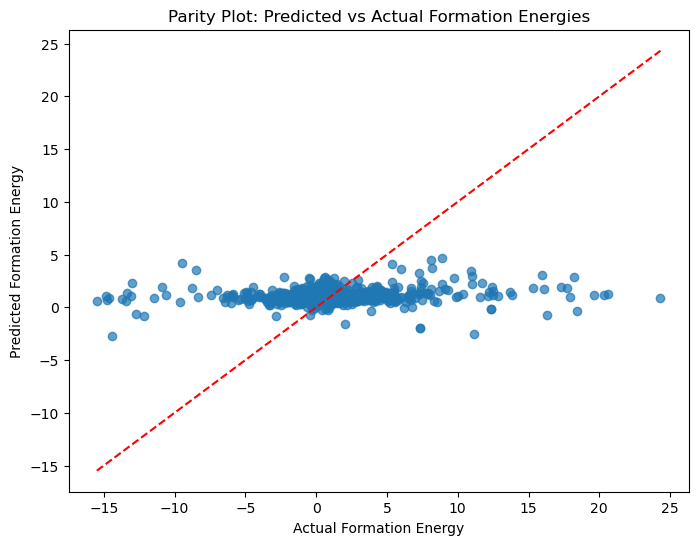

In [13]:
# Plotting parity plot
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.7)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Ideal diagonal line
plt.xlabel("Actual Formation Energy")
plt.ylabel("Predicted Formation Energy")
plt.title("Parity Plot: Predicted vs Actual Formation Energies")
plt.show()